# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

September 27, 2025

This tutorial demonstrates the usage of **nbragg** to model and fit Bragg-edge transmission spectra of an iron powder.

Repository: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

> 💡 **Tip:** Run cells in order. Sections are intentionally short and task-oriented.

# Installation
Install directly from GitHub:

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

> Use `--upgrade` to update an existing install.

In [1]:
import nbragg

# Quick start
Minimal end-to-end example:
1. load data
2. define material
3. build model
4. fit
5. plot.

This example uses the default Rietveld fitting method, which accumulates parameters across stages. We also set custom fitting stages to control the refinement process.

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

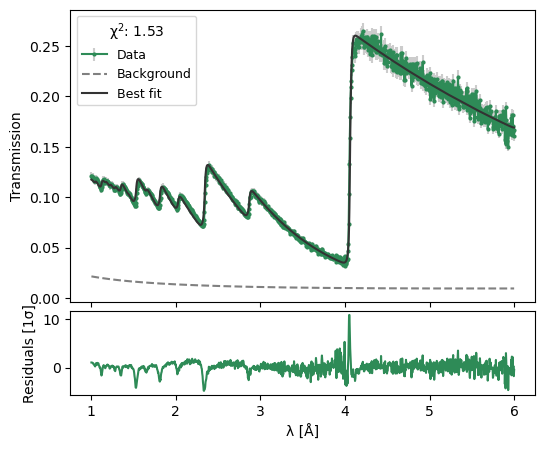

In [2]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")            # read data
xs = nbragg.CrossSection(iron="Fe_sg229_Iron-alpha.ncmat")                      # define sample
model = nbragg.TransmissionModel(xs, vary_background=True, vary_response=True)   # define model
result = model.fit(data)                                                         # perform fit
result.plot();                                                                   # plot results

# Load data
Use the `nbragg.Data` object to read Bragg-edge data from CSV.

In [3]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")

The data is available as a table via `data.table`. Use `data.plot()` for a quick look.

In [ ]:
data.table

In [ ]:
data.plot()

## Define samples
Define the composition of the sample. You can choose predefined crystalline materials from the **NCrystal** standard library, available under the `nbragg.materials` dictionary.

In [ ]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

Use the `nbragg.CrossSection` method to load a single material from the library.

In [ ]:
gamma = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the NCrystal library using `nbragg.utils.register_material`, then access them from `nbragg.materials` the same way.

In [ ]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can combine materials by simple addition. The `cfg_string` will use NCrystal's `phases` syntax to define a multiphase material. Optional weights can be provided by scaling each component.

In [ ]:
xs = alpha + gamma

# or with weights
xs = alpha*0.3 + gamma*0.7

In [ ]:
xs.cfg_string

Access the cross-section data via `xs.table` and plot with `xs.plot()`.

In [ ]:
xs.table

In [ ]:
xs.plot();

# Define a transmission model
The fit process in **nbragg** uses the friendly `lmfit` parameter framework.

Construct a `TransmissionModel` from a `CrossSection`, and enable optional model components via flags. Here we vary background, instrument response, and time-of-flight parameters.

In [ ]:
model = nbragg.TransmissionModel(alpha, background="polynomial3", vary_background=True, vary_response=True)

In [ ]:
model.params  # Inspect default parameter set

In [ ]:
model

# Fit
After adjusting parameters (optional), call `model.fit` to perform the fit over a chosen wavelength window. By default, the fit uses the Rietveld method, which accumulates parameters across stages defined in `model.stages`. You can customize the fitting stages to control which parameters are refined in each stage.

In [ ]:
# Define custom stages
model.stages = {'basic': ['norm', 'thickness'], 
                'background': 'background', 
                'response': 'response'}
result = model.fit(data, wlmin=1, wlmax=5)

In [ ]:
result.plot();

In [ ]:
result  # Summary including chi2, parameter values, and uncertainties

# Customizing Fitting Stages
The `TransmissionModel` uses the Rietveld fitting method by default, which refines parameters across multiple stages, accumulating them to improve the fit. You can customize the stages to control which parameters are varied in each stage, allowing you to prioritize certain aspects of the model (e.g., scaling, background, phase weights, or instrument response) and improve convergence. Below, we demonstrate two ways to change the fitting stages using the `xs` cross-section, which combines alpha and gamma iron phases.

## Method 1: Set Stages via `model.stages`
You can define stages by setting the `model.stages` attribute before calling `fit`. This is useful when you want to reuse the same stage configuration for multiple fits.

Here, we define four stages: one for scaling parameters (`norm` and `thickness`), one for background parameters (e.g., `b0`, `b1`), and one for the phase weights.

In [ ]:
# Create model with weights, background, and response
model = nbragg.TransmissionModel(xs, vary_background=True, vary_weights=True, vary_response=True)

# Define custom stages
model.stages = {
    'scale': ['norm', 'thickness'],
    'background': 'background',
    'weights': ['weights']
}

# Perform fit
result_stages1 = model.fit(data, wlmin=2, wlmax=5)

# Plot results
result_stages1.plot();

In this example, the fit first optimizes the scaling parameters (`norm` and `thickness`), then the background parameters (e.g., `bg0`, `bg1`), followed by the phase weights, and finally the instrument response parameters. The `model.stages` attribute persists, so subsequent calls to `fit` will reuse these stages unless changed.

## Method 2: Pass Stages to `fit`
You can pass a `stages` dictionary directly to the `fit` method to override the default or `model.stages` for a single fit. This is useful for testing different stage configurations without modifying the model.

Here, we use a different approach, first optimizing scaling and background parameters together, then refining phase weights and instrument response parameters in a second stage.

In [ ]:
# Create model with weights, background, and response
model = nbragg.TransmissionModel(xs, vary_background=True, vary_weights=True, vary_response=True)

# Define stages for this fit only
stages = {
    'scale_and_background': ['norm', 'thickness', 'bg0', 'bg1', 'bg2'],
    'weights_and_response': ['weights','response']
}

# Perform fit with custom stages
result_stages2 = model.fit(data, wlmin=2, wlmax=5, stages=stages)

# Plot results
result_stages2.plot();

In this example, the fit first optimizes the scaling parameters (`norm`, `thickness`) and background parameters together, then refines the phase weights in a second stage. This can lead to different convergence behavior compared to Method 1. The `stages` argument overrides `model.stages` for this fit only, leaving `model.stages` unchanged for future fits.

> 💡 **Tip:** Use `result.stages_summary` to inspect the parameters and chi-squared values for each stage after fitting.

In [ ]:
# Compare stage summaries
print("Method 1 Stages Summary:")
result_stages1.stages_summary

In [ ]:
print("\nMethod 2 Stages Summary:")
result_stages2.stages_summary

# SANS (Small Angle Neutron Scattering)

**nbragg** supports SANS hard-sphere modeling to account for small-angle scattering contributions in your neutron transmission data. This is particularly useful when your sample contains nanoscale features or voids that produce SANS signals.

SANS modeling uses NCrystal's hard-sphere SANS model, which requires specifying the sphere radius in Angstroms. When SANS is enabled, **nbragg** automatically adds a small void phase (0.01 fraction) as required by NCrystal's implementation.

## Defining materials with SANS

You can add SANS parameters to your material definitions by including the `sans` key with the sphere radius in Angstroms.

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

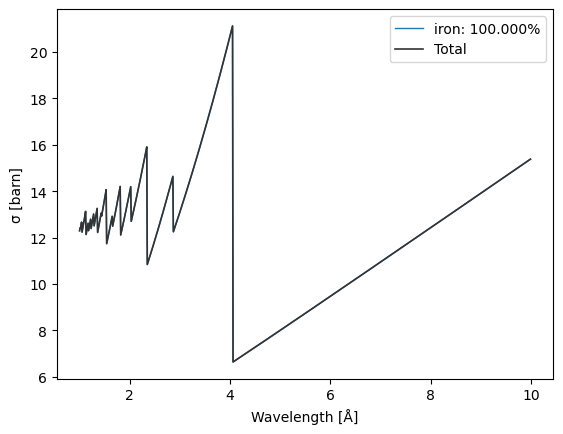

In [8]:
xs.plot()

In [14]:
# Single material with SANS
xs_sans = nbragg.CrossSection({
    'aluminum': {
        'mat': 'Al_sg225.ncmat',
        'sans': 250.0  # 50 Angstrom sphere radius
    }
})

# Inspect the material
xs_sans.materials

{'aluminum': {'mat': 'Al_sg225.ncmat',
  'temp': 300.0,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': 250.0,
  'weight': 1.0}}

In [19]:
print(xs_sans.textdata["aluminum"])

NCMAT v7
# Autogenerated by NCMATComposer
#
# Al (cubic, SG-225)
#
# Atoms per unit cell: 4xAl
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.04958
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al 0 0 0
  Al 0 1/2 1/2
  Al 1/2 0 1/2
  Al 1/2 1/2 0
@OTHERPHASES
  0.01 void.ncmat
@CUSTOM_HARDSPHERESANS
  250.0 #sphere radius in angstrom.
@DYNINFO
  # Transferred from "Al" in existing NCrystal.DynamicInfo object
  element Al
  fraction 1
  type vdos
  vdos_egrid .00485015 .0398222
  vdos_density .013232 .0141193 .0150065 .0158938 .0167811 .0176684 .0185557
     .0195536 .020725 .0218964 .0230678 .0242392 .0254106 .0265808 .027748
     .0289152 .0300825 .0312497 .032417 .0338129 .0352559 .0366988 .0381418
     .0395847 .0412955 .043043 .0447906 .0465382 .0482858 .0500848 .0519404
     .0537959 .0556515 .057507 .0593626 .0613858 .0638226 .0662593 .0686961
     .0711328 .0735696 .0760063 .0785759 .081366 .0841561 .0869462 .0897363
     .0925265 .0954792 

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

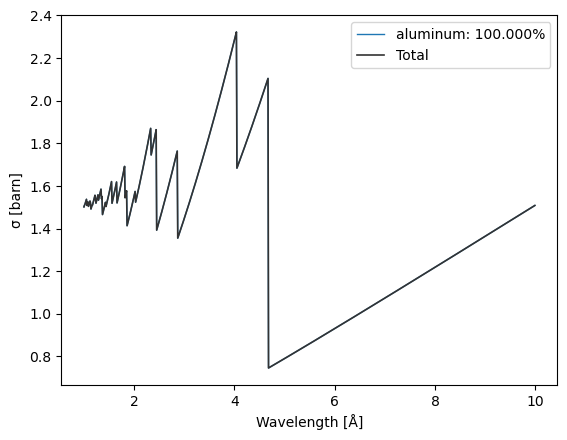

In [21]:
xs_sans.plot()

## Multi-phase materials with SANS

You can define different SANS parameters for each phase in a multi-phase material. This is useful when different phases have different microstructural features.

In [22]:
# Multi-phase material with different SANS radii
xs_multiphase_sans = nbragg.CrossSection({
    'alpha': {
        'mat': 'Fe_sg229_Iron-alpha.ncmat',
        'sans': 30.0,  # 30 Angstrom for alpha phase
        'weight': 0.4
    },
    'gamma': {
        'mat': 'Fe_sg225_Iron-gamma.ncmat',
        'sans': 60.0,  # 60 Angstrom for gamma phase
        'weight': 0.6
    }
})

# Check the materials
xs_multiphase_sans.materials

{'alpha': {'mat': 'Fe_sg229_Iron-alpha.ncmat',
  'temp': 300.0,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': 30.0,
  'weight': 0.4},
 'gamma': {'mat': 'Fe_sg225_Iron-gamma.ncmat',
  'temp': 300.0,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': 60.0,
  'weight': 0.6}}

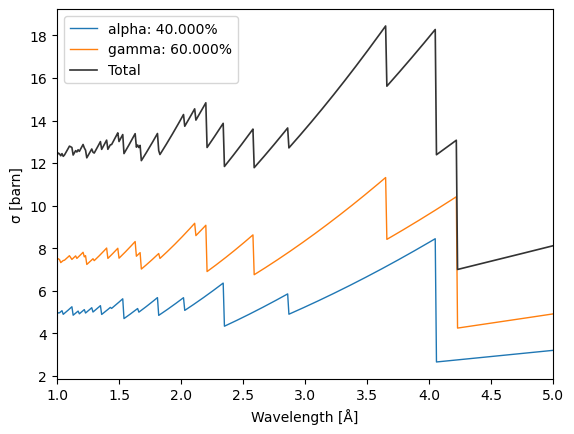

In [23]:
# Plot the cross-section with SANS
xs_multiphase_sans.plot(xlim=(1, 5));

## Fitting SANS parameters

To fit SANS parameters during Rietveld analysis, use the `vary_sans=True` flag when creating the `TransmissionModel`. The SANS sphere radius will then be included as a fittable parameter.

In [24]:
# Create model with SANS fitting enabled
model_sans = nbragg.TransmissionModel(
    xs_sans, 
    vary_background=True, 
    vary_sans=True  # Enable SANS parameter fitting
)

# Inspect SANS parameters
print("SANS parameters:")
for param_name in model_sans.params:
    if 'sans' in param_name:
        param = model_sans.params[param_name]
        print(f"  {param_name}: value={param.value}, vary={param.vary}, min={param.min}, max={param.max}")

SANS parameters:
  sans: value=250.0, vary=True, min=0.0, max=1000


For multi-phase materials, each phase gets its own SANS parameter with a numeric suffix (sans1, sans2, etc.):

In [25]:
# Create model for multi-phase material with SANS
model_multiphase_sans = nbragg.TransmissionModel(
    xs_multiphase_sans,
    vary_background=True,
    vary_weights=True,
    vary_sans=True
)

# Inspect SANS parameters for each phase
print("SANS parameters for multi-phase material:")
for param_name in model_multiphase_sans.params:
    if 'sans' in param_name:
        param = model_multiphase_sans.params[param_name]
        print(f"  {param_name}: value={param.value}, vary={param.vary}")

SANS parameters for multi-phase material:
  sans1: value=30.0, vary=True
  sans2: value=60.0, vary=True


## Using SANS in staged fitting

SANS parameters can be included in your custom fitting stages just like any other parameter. This allows you to control when SANS is refined relative to other parameters.

In [26]:
# Define custom stages including SANS
model_multiphase_sans.stages = {
    'basic': ['norm', 'thickness'],
    'background': 'background',
    'weights': 'weights',
    'sans': 'sans'  # Refine SANS parameters in final stage
}

# View the stages
model_multiphase_sans.stages

{'basic': ['norm', 'thickness'],
 'background': 'background',
 'weights': 'weights',
 'sans': 'sans'}

You can also specify individual SANS parameters for different phases:

In [27]:
# Refine SANS parameters for each phase separately
custom_stages = {
    'basic': ['norm', 'thickness'],
    'background': 'background',
    'weights': 'weights',
    'sans_alpha': ['sans1'],  # Only alpha phase SANS
    'sans_gamma': ['sans2']   # Only gamma phase SANS
}

# Or refine both together
combined_stages = {
    'basic': ['norm', 'thickness'],
    'background': 'background',
    'weights': 'weights',
    'sans_both': ['sans1', 'sans2']  # Both phases together
}

print("Custom stages (separate):", custom_stages)
print("\nCombined stages:", combined_stages)

Custom stages (separate): {'basic': ['norm', 'thickness'], 'background': 'background', 'weights': 'weights', 'sans_alpha': ['sans1'], 'sans_gamma': ['sans2']}

Combined stages: {'basic': ['norm', 'thickness'], 'background': 'background', 'weights': 'weights', 'sans_both': ['sans1', 'sans2']}


## Updating SANS parameters dynamically

You can update SANS parameters on-the-fly using the CrossSection's `__call__` method, similar to other material parameters:

In [28]:
import nbragg

In [29]:
xs = nbragg.CrossSection(iron=nbragg.materials["Fe_sg225_Iron-gamma"])
xs.materials["sans"] = 300
xs.update()

TypeError: Material 'sans' is not a dictionary. Did you mean to set xs.materials['iron']['sans'] instead of xs.materials['sans']?

In [ ]:
print(xs.textdata["iron"])

In [ ]:
xs.plot()

In [30]:
import numpy as np

# Create wavelength array
wl = np.linspace(1, 5, 100)

# For single-phase material, use 'sans'
xs = nbragg.CrossSection(wl, sans=55.0)
print(f"Updated SANS radius: {xs_sans.materials['aluminum']['sans']} Å")

# For multi-phase material, use 'sans1', 'sans2', etc.
xs_multiphase_sans(wl, sans1=35.0, sans2=65.0)
print(f"Alpha SANS radius: {xs_multiphase_sans.materials['alpha']['sans']} Å")
print(f"Gamma SANS radius: {xs_multiphase_sans.materials['gamma']['sans']} Å")

ValueError: Material specification for sans must be a dictionary or string

You can also update SANS by modifying the materials dictionary directly and calling `update()`:

In [31]:
# Update SANS via materials dict
xs_sans.materials['aluminum']['sans'] = 75.0  # CORRECT: material_name['parameter']
xs_sans.update()

print(f"Updated SANS radius: {xs_sans.materials['aluminum']['sans']} Å")
print("Has CUSTOM_HARDSPHERESANS:", '@CUSTOM_HARDSPHERESANS' in xs_sans.textdata['aluminum'])

# WRONG way (this will raise an error):
# xs_sans.materials['sans'] = 75.0  # ❌ INCORRECT - 'sans' is not a material name!

Updated SANS radius: 75.0 Å
Has CUSTOM_HARDSPHERESANS: True


<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

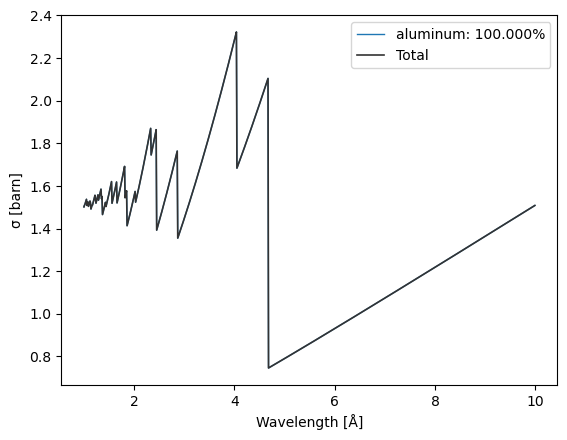

In [32]:
xs_sans.plot()

## Key points about SANS in nbragg

- **SANS parameter**: Specifies the hard-sphere radius in Angstroms
- **Automatic void phase**: When SANS is enabled, a small void phase (0.01 fraction) is automatically added as required by NCrystal
- **Multi-phase support**: Each phase can have its own SANS radius
- **Parameter naming**: 
  - Single phase: `sans`
  - Multi-phase: `sans1`, `sans2`, etc. (numbered by phase order)
- **Fitting bounds**: SANS parameters are bounded between 0 and 1000 Angstroms
- **Integration with Rietveld**: Use `vary_sans=True` to include SANS in the fitting process
- **Staged refinement**: SANS can be refined in specific stages using the `'sans'` group or individual parameters (`'sans1'`, `'sans2'`, etc.)

> 💡 **Tip:** SANS is most useful for samples with nanoscale features. If your sample is purely crystalline without nanoscale porosity or inclusions, you may not need SANS modeling.

# Oriented materials

You can load **oriented** materials by specifying crystal directions relative to the beam axis.

- `dir1`: a crystal direction aligned relative to the beam (assumed z-axis).
- `dir2`: a second crystal direction relative to the y-axis.
- `theta` and `phi`: additional rotations around z and y axes (degrees).
- `mos`: mosaicity (degrees) for each phase.

Below is an example multiphase oriented material.

In [ ]:
nbragg.materials["Be_sg194.ncmat"]

In [ ]:
gamma =     {
            "mat": "Fe_sg225_Iron-gamma.ncmat",
            "temp": 300,
            "weight": 0.3
            }
beryllium = {
            "mat": "Be_sg194.ncmat",
            "temp": 300,
            "mos": 3,
            "dir1": [0, 0, 1],
            "dir2": [1, 0, 0],
            "theta": 10.0,
            "phi": 10.0,
            "weight": 0.7,
            "dirtol": 30
            }
xs2 = nbragg.CrossSection(gamma=gamma, beryllium=beryllium)

In [ ]:
xs2.materials  # Inspect phase definitions

The configuration string reflects the oriented phases and parameters.

In [ ]:
xs2.cfg_string

In [ ]:
xs2.plot()

Oriented materials can be combined with other (oriented/non-oriented) materials using the same syntax as before.

In [ ]:
xs3 = xs2*0.2 + xs*0.8

In [ ]:
xs3.phases  # Combined phases

In [ ]:
xs3.plot()

# MTEX integration
MTEX (MATLAB) can analyze diffraction peaks to infer phase fractions and textures; those can seed the Bragg-edge model in **nbragg**.

Use the MATLAB scripts in the repository (`mtex_scripts/`) to export predicted phase weights, directions, and mosaicities to CSV. See the **mtex integration README** for details.

The scripts output a CSV with phase weights, orientation vectors, and mosaicity. You can load this with `nbragg.CrossSection.from_mtex` to create a multiphase `CrossSection`.

In [ ]:
xs_alpha = nbragg.CrossSection.from_mtex(
    "sf_alpha_ncrystal.csv",
    nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"],
    short_name="α",
)

xs_gamma = nbragg.CrossSection.from_mtex(
    "sf_gamma_ncrystal.csv",
    nbragg.materials["Fe_sg225_Iron-gamma_LGS.ncmat"],
    short_name="γ",
)

In [ ]:
xs_gamma.materials  # Inspect the phases imported from MTEX

In [ ]:
xs_gamma.plot(xlim=(1, 5));

# Fitting Large-Grain Steel Data


We'll use the MTEX-generated materials to fit a multiphase large-grain steel sample.

## Load data
Use `nbragg.Data.from_counts(signal_csv, openbeam_csv)` with two CSV files: the sample **signal** and the **open-beam** reference.

Each CSV should have three columns:
- **slice**: Identifier for each slice of the sample,
- **counts**: Measured counts for each slice,
- **error**: Measurement error associated with each count value.

In [ ]:
data = nbragg.Data.from_counts("large_grain_steel_0deg.csv", "openbeam.csv")

In [ ]:
data.plot(ylim=(0, 0.2))

Define a model based on the MTEX-derived **iron-gamma** cross section.

In [ ]:
model = nbragg.TransmissionModel(xs_gamma, vary_background=True, vary_weights=True)

In [ ]:
model.params["norm"].value = 1.0/2.3
model.params["thickness"].value = 1.27
model.params["thickness"].vary = True
model.params  # Review current parameters

In [ ]:
result = model.fit(data, wlmin=2, wlmax=5)

In [ ]:
result.plot();

In [ ]:
result

Now we also vary the **orientation**.

In [ ]:
model = nbragg.TransmissionModel(
    xs_gamma,
    vary_background=True,
    vary_weights=True,
    vary_orientation=True,
)
# Example: reuse previous best params (optional)
model.update_params(result.params)
model.params["thickness"].vary = False
model.params["norm"].vary = False
model.params

In [ ]:
model.stages

In [ ]:
model.stages = {'basic': 'basic',
 'background': 'background',
 # 'mosaicity': 'mosaicity',
 'thetas': 'thetas',
 # 'phis': 'phis',
 # 'angles': 'angles',
 # 'orientation': 'orientation',
 'weights': 'weights'}
result2 = model.fit(data, wlmin=2, wlmax=5)

In [ ]:
result2.plot();